# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

## Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import random
import time
import torch

env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

# Training

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
PRINT_EVERY = 50
add_noise = True

def maddpg(n_episodes=5000, max_t=2000, train_mode=True):
    
    print('\rTraining launched.')

    scores_window = deque(maxlen=100)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent0.reset()
        agent1.reset()
        scores = np.zeros(num_agents)
        while True:
            action0 , action1 = agent0.act(states, add_noise) , agent1.act(states, add_noise)  
            actions = np.concatenate((action0, action1), axis=0).flatten()           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episode {}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, np.max(scores_all[-PRINT_EVERY:]), moving_average[-1]))

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= 0.5:
            if not already_solved:
                print('\nEnvironment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past 100 episodes\n'.format(
                    i_episode, moving_average[-1]))
                already_solved = True
                # save weights
                torch.save(agent0.actor_local.state_dict(), 'weights/checkpointactor0.pth')
                torch.save(agent0.critic_local.state_dict(), 'weights/checkpointcritic0.pth')
                torch.save(agent1.actor_local.state_dict(), 'weights/checkpointactor1.pth')
                torch.save(agent1.critic_local.state_dict(), 'weights/checkpointcritic1.pth')
            elif ep_best_score >= best_score:
                print('\nBest episode\
                \nEpisode : {}\tMax Reward: {:.3f}\tMoving Average: {:.3f}\n'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent0.actor_local.state_dict(), 'weights/checkpointactor0.pth')
                torch.save(agent0.critic_local.state_dict(), 'weights/checkpointcritic0.pth')
                torch.save(agent1.actor_local.state_dict(), 'weights/checkpointactor1.pth')
                torch.save(agent1.critic_local.state_dict(), 'weights/checkpointcritic1.pth')
            elif (i_episode-best_episode) >= 500:
                # stop training if model stops converging
                print('Training stopped. Best score not matched or exceeded for 500 episodes')
                break
            else:
                continue
            
    return scores_all, moving_average

In [7]:
from workspace_utils import active_session

agent0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

seed = 16

with active_session():
    scores, avgs = maddpg()

Training launched.
Episode 50	Max Reward: 0.200	Moving Average: 0.008
Episode 100	Max Reward: 0.100	Moving Average: 0.009
Episode 150	Max Reward: 0.100	Moving Average: 0.009
Episode 200	Max Reward: 0.100	Moving Average: 0.007
Episode 250	Max Reward: 0.200	Moving Average: 0.007
Episode 300	Max Reward: 0.200	Moving Average: 0.011
Episode 350	Max Reward: 0.100	Moving Average: 0.008
Episode 400	Max Reward: 0.100	Moving Average: 0.004
Episode 450	Max Reward: 0.100	Moving Average: 0.007
Episode 500	Max Reward: 0.100	Moving Average: 0.009
Episode 550	Max Reward: 0.200	Moving Average: 0.012
Episode 600	Max Reward: 0.300	Moving Average: 0.018
Episode 650	Max Reward: 0.100	Moving Average: 0.017
Episode 700	Max Reward: 0.100	Moving Average: 0.015
Episode 750	Max Reward: 0.200	Moving Average: 0.022
Episode 800	Max Reward: 0.100	Moving Average: 0.018
Episode 850	Max Reward: 0.300	Moving Average: 0.019
Episode 900	Max Reward: 0.100	Moving Average: 0.018
Episode 950	Max Reward: 0.100	Moving Average: 

# Training

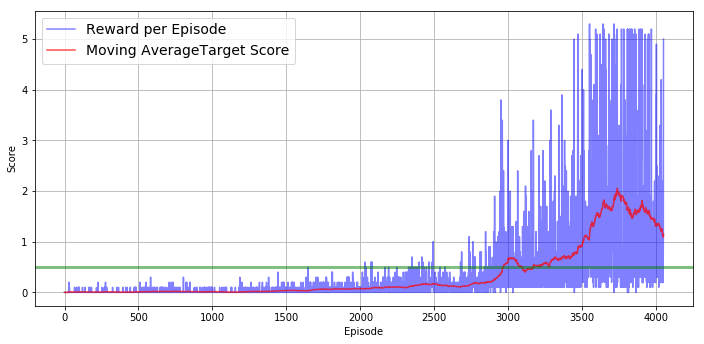

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

ax.plot(scores, "-", c="blue", alpha=0.5)
ax.plot(avgs, "-", c="red", alpha=0.7)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(0.5, c="green", linewidth=3, alpha=0.5)
ax.legend(["Reward per Episode","Moving Average" "Target Score"])

fig.tight_layout()

# Testing a trained agent

In [4]:
agent0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

agent0.actor_local.load_state_dict(torch.load('weights/checkpointactor0.pth',map_location='cpu'))
agent0.critic_local.load_state_dict(torch.load('weights/checkpointcritic0.pth',map_location='cpu'))
agent1.actor_local.load_state_dict(torch.load('weights/checkpointactor1.pth',map_location='cpu'))
agent1.critic_local.load_state_dict(torch.load('weights/checkpointcritic1.pth',map_location='cpu'))

In [ ]:
for i in range(10):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]         # reset the environment
    states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
    agent0.reset()
    agent1.reset()
    scores = np.zeros(num_agents)
    while True:
        action0 , action1 = agent0.act(states, add_noise=False) , agent1.act(states, add_noise=False)  
        actions = np.concatenate((action0, action1), axis=0).flatten()           # choose agent actions and combine them
        env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
        next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
        rewards = env_info.rewards                         # get reward
        done = env_info.local_done                         # see if episode finished
        agent0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
        agent1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
        scores += np.max(rewards)                          # update the score for each agent
        states = next_states                               # roll over states to next time step
        if np.any(done):                                   # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [6]:
env.close()